In [1]:
! pip install autogluon

In [2]:
! pip install phate

In [3]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data

from tensorflow import keras

from torch.optim import Adam, SGD
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Bidirectional, Conv1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Add

In [4]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import SimpleRNN, LSTM

In [5]:
from tensorflow import convert_to_tensor
import tensorflow as tf

In [6]:
# genomics-specific visualization tools
import phate
import scprep

from sklearn.manifold import TSNE

import seaborn as sns

In [7]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [8]:
from pathlib import Path

DATA = Path("/gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project")

In [9]:
import sys
sys.path.append(DATA)

In [10]:
%cd /gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project

/gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project


In [11]:
# .py file created with helper functions
from utils import *

## Load Data and Clean it

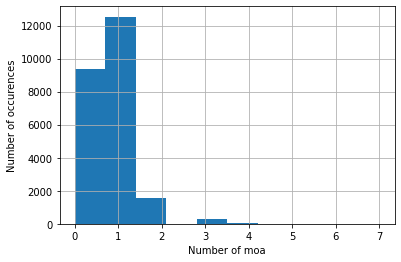

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.3,
            train_size=None)
StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.7,
            train_size=None)


In [12]:
# load data
df_feature, df_labels, df_raw = read_data(DATA)

# get number of moa per row, and plot histogram
n_moa = get_n_moa(df_labels)
get_plot_n_moa(df_labels)

# remove ids that have more than 1 moa or less than 1 moa
n_moa_feature, n_moa_labels = get_n_moa_per_row(df_feature, df_labels, n_moa_per_row=1)
# remove labels that occur less than min_label_occur param
sel_labels, sel_raw = sel_labels_by_occur(n_moa_labels, df_raw, min_label_occur=100)
# split data into test train and val
df_feat, df_lab = get_test_train_val(n_moa_feature, sel_labels)
# get split labels, make them categories (int) instead of hot encoded
train_labels, test_labels, val_labels = split_labels_train_test_val(df_lab)
# get split features in pandas DataFrame
train_features, test_features, val_features = split_features_train_test_val(df_feat, in_numpy=False)
# get split features in numpy ndarray
nptrain_features, nptest_features, npval_features = split_features_train_test_val(df_feat, in_numpy=True)

In [13]:
n_moa_feature.head()

,id,with_drug,time,dosage,drug,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,dtype
0,id_000644bb2,True,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,test
1,id_001626bd3,True,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,test
2,id_001762a82,True,24,D1,e06749542,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,0.0543,-0.2225,-0.1586,0.4289,0.0361,0.3543,0.8310,-0.9129,0.7677,-0.2512,0.7087,0.0481,-0.4486,1.2570,1.2550,0.3359,-0.5103,-0.2993,-1.1950,-0.3208,-0.1187,1.0030,0.9133,0.0376,0.3015,-0.9578,0.5354,1.1360,1.1310,...,2.0780,1.3350,0.9889,0.5017,2.0020,0.8918,0.4290,0.0716,0.8465,0.6596,1.3710,1.0580,1.7570,1.0030,0.2152,1.6920,-0.2930,1.4590,1.0950,0.5854,1.7270,0.5580,1.3090,1.0100,0.6980,0.5455,1.0170,1.2910,1.5430,1.8390,1.1570,-1.0120,1.9010,1.4270,0.4519,1.2120,0.3765,0.7848,1.3990,test
3,id_0020d0484,True,48,D1,8b87a7a83,0.2711,0.5133,-0.1327,2.5950,0.6980,0.5846,-0.2633,-2.1490,0.4881,1.4750,-0.0488,-0.0561,0.1641,0.1749,-0.3464,-0.1811,0.5685,1.2970,1.0510,-0.9585,0.7911,-0.2991,2.7420,-0.5979,-1.0240,0.7268,0.1590,-1.9730,1.1340,-2.5720,0.2068,0.9992,-0.1958,0.2262,1.0140,...,-0.5500,-0.0530,0.2077,-0.0825,0.2156,0.8142,1.0990,1.0860,0.4011,-0.1342,0.4653,-0.1104,0.3935,1.2370,-0.5072,0.0351,0.5084,-0.1248,0.4351,0.1389,0.6726,0.6070,0.3431,-0.4116,0.1194,0.3420,0.1331,0.8541,0.6282,0.3230,-0.4140,0.2532,0.0513,0.8600,1.4250,0.6633,0.4562,-0.9622,0.0260,test
4,id_0023f063e,True,48,D2,de7583071,-0.0630,0.2564,-0.5279,-0.2541,-0.0182,-1.5370,-0.2180,-0.0430,-0.0116,0.6565,-0.1618,-0.6742,0.7260,-0.8124,0.3477,0.2425,1.2030,-0.4435,0.8795,-0.2243,-0.1423,0.3758,-0.6869,0.2382,-0.8178,-0.7586,1.2330,1.0770,0.3447,-0.3917,0.3276,2.2610,-0.1933,0.2296,-0.1599,...,-0.0834,-0.8118,-0.4018,-1.2540,-0.9295,-0.5881,-0.8408,-0.1703,-0.0097,0.1205,-0.5683,-0.5235,-0.8461,-0.8039,-1.1390,-0.3498,-0.2183,-0.3053,-0.6116,-0.1504,-0.5320,-1.1000,-0.2852,-0.5361,-0.3377,-0.2916,-1.4360,0.3119,-1.0490,0.2201,0.5601,-0.3501,-1.4070,-0.1717,-1.1160,-0.8745,-0.2716,0.0189,-2.0000,test


In [39]:
print(f'Selected data shapes (features, labels): {(df_feat.shape, df_lab.shape)}')

Selected data shapes (features, labels): ((12532, 878), (12532, 31))


In [40]:
# get gene expression only
gene_exp_feat = get_gene_exp_features(df_feat, in_numpy=False)
npgene_exp_feat = get_gene_exp_features(df_feat, in_numpy=True)

In [41]:
# see if it worked properly
gene_exp_feat.head()

,id,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,...,g-732,g-733,g-734,g-735,g-736,g-737,g-738,g-739,g-740,g-741,g-742,g-743,g-744,g-745,g-746,g-747,g-748,g-749,g-750,g-751,g-752,g-753,g-754,g-755,g-756,g-757,g-758,g-759,g-760,g-761,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
0,id_000644bb2,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,-0.5055,-0.5119,...,-0.9041,-0.8089,0.6598,-0.4772,0.1289,-0.0297,0.4564,-0.1447,0.4683,-0.1722,0.9998,1.2860,-0.6166,0.0963,1.6340,-0.8744,0.4931,-0.0283,-0.3110,-0.1117,-0.4528,1.3240,-0.0503,-1.2750,-0.1750,-0.6972,-0.2720,0.2931,1.5280,0.3453,-0.5055,-0.3167,1.0930,0.0084,0.8611,-0.5582,0.3008,1.6490,0.2968,-0.0224
1,id_001626bd3,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,-1.4470,1.0620,0.7888,...,-0.2094,1.1270,0.1874,-0.0465,1.0560,-0.6324,-0.3651,0.9485,-0.6745,0.0479,-1.0470,-1.2440,-0.7675,0.2327,0.3698,1.4900,0.3632,1.4380,-0.5047,-0.2092,-0.4386,-1.1780,0.8236,1.0540,0.6745,-0.6354,-0.6745,-1.3780,0.7521,-0.9456,-0.6904,2.0540,-0.3131,-0.0809,0.3910,1.7660,-1.0020,-0.7534,0.5000,-0.6269
2,id_001762a82,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,0.0543,-0.2225,-0.1586,0.4289,0.0361,0.3543,0.8310,-0.9129,0.7677,-0.2512,0.7087,0.0481,-0.4486,1.2570,1.2550,0.3359,-0.5103,-0.2993,-1.1950,-0.3208,-0.1187,1.0030,0.9133,0.0376,0.3015,-0.9578,0.5354,1.1360,1.1310,-0.1430,-0.0559,0.5950,-1.0050,...,0.2347,1.7340,-0.3179,-0.0674,0.0625,0.2568,0.3574,-1.5220,0.6799,-0.1855,-0.3658,0.7496,0.5610,1.1440,-0.5849,1.1840,0.5497,0.0238,0.1425,-0.0735,-1.9930,-0.0062,-0.1116,-1.7200,0.0000,-0.0169,0.7212,-0.7499,-0.0713,-0.7886,0.1126,0.4842,-0.4471,0.1982,0.1351,0.1498,-0.4674,0.9579,0.1993,0.0592
3,id_0020d0484,0.2711,0.5133,-0.1327,2.5950,0.6980,0.5846,-0.2633,-2.1490,0.4881,1.4750,-0.0488,-0.0561,0.1641,0.1749,-0.3464,-0.1811,0.5685,1.2970,1.0510,-0.9585,0.7911,-0.2991,2.7420,-0.5979,-1.0240,0.7268,0.1590,-1.9730,1.1340,-2.5720,0.2068,0.9992,-0.1958,0.2262,1.0140,1.3170,-2.4110,-6.3870,0.6364,...,-0.4459,-1.4550,0.4910,-1.8030,0.5707,-0.5121,-0.7822,0.0237,-0.3289,0.0651,-0.8492,-1.1390,2.4410,3.1790,0.5241,0.6403,0.3883,-0.5364,2.5070,0.0365,1.4730,0.9430,0.4221,-0.4104,0.0000,2.5800,-1.5910,-0.1997,-0.2239,-4.5060,0.3843,3.0690,-0.7682,1.3920,-1.9820,-1.8910,1.1250,0.6872,0.0641,1.3280
4,id_0023f063e,-0.0630,0.2564,-0.5279,-0.2541,-0.0182,-1.5370,-0.2180,-0.0430,-0.0116,0.6565,-0.1618,-0.6742,0.7260,-0.8124,0.3477,0.2425,1.2030,-0.4435,0.8795,-0.2243,-0.1423,0.3758,-0.6869,0.2382,-0.8178,-0.7586,1.2330,1.0770,0.3447,-0.3917,0.3276,2.2610,-0.1933,0.2296,-0.1599,0.0780,0.5552,-0.9599,-0.3522,...,0.8607,0.0162,0.6687,0.4723,-1.3410,0.3620,-0.4446,-0.2199,-0.6276,0.5777,-0.6095,0.1234,0.2875,1.2330,0.8081,0.2056,-0.5950,-0.0282,-0.0811,0.6988,0.3676,-0.5809,-0.7153,-0.7473,-0.4396,-0.4507,0.8305,-0.2183,-0.5124,-0.1496,-0.4106,1.3090,0.7485,0.5926,-0.6437,-0.0956,-0.4281,0.6985,-0.8000,0.7218


In [42]:
get_c_g_features(df_feat, in_numpy=False).head()

,id,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,-0.5055,-0.5119,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_001626bd3,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,-1.4470,1.0620,0.7888,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
2,id_001762a82,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,0.0543,-0.2225,-0.1586,0.4289,0.0361,0.3543,0.8310,-0.9129,0.7677,-0.2512,0.7087,0.0481,-0.4486,1.2570,1.2550,0.3359,-0.5103,-0.2993,-1.1950,-0.3208,-0.1187,1.0030,0.9133,0.0376,0.3015,-0.9578,0.5354,1.1360,1.1310,-0.1430,-0.0559,0.5950,-1.0050,...,0.6701,2.0780,1.3350,0.9889,0.5017,2.0020,0.8918,0.4290,0.0716,0.8465,0.6596,1.3710,1.0580,1.7570,1.0030,0.2152,1.6920,-0.2930,1.4590,1.0950,0.5854,1.7270,0.5580,1.3090,1.0100,0.6980,0.5455,1.0170,1.2910,1.5430,1.8390,1.1570,-1.0120,1.9010,1.4270,0.4519,1.2120,0.3765,0.7848,1.3990
3,id_0020d0484,0.2711,0.5133,-0.1327,2.5950,0.6980,0.5846,-0.2633,-2.1490,0.4881,1.4750,-0.0488,-0.0561,0.1641,0.1749,-0.3464,-0.1811,0.5685,1.2970,1.0510,-0.9585,0.7911,-0.2991,2.7420,-0.5979,-1.0240,0.7268,0.1590,-1.9730,1.1340,-2.5720,0.2068,0.9992,-0.1958,0.2262,1.0140,1.3170,-2.4110,-6.3870,0.6364,...,-0.2623,-0.5500,-0.0530,0.2077,-0.0825,0.2156,0.8142,1.0990,1.0860,0.4011,-0.1342,0.4653,-0.1104,0.3935,1.2370,-0.5072,0.0351,0.5084,-0.1248,0.4351,0.1389,0.6726,0.6070,0.3431,-0.4116,0.1194,0.3420,0.1331,0.8541,0.6282,0.3230,-0.4140,0.2532,0.0513,0.8600,1.4250,0.6633,0.4562,-0.9622,0.0260
4,id_0023f063e,-0.0630,0.2564,-0.5279,-0.2541,-0.0182,-1.5370,-0.2180,-0.0430,-0.0116,0.6565,-0.1618,-0.6742,0.7260,-0.8124,0.3477,0.2425,1.2030,-0.4435,0.8795,-0.2243,-0.1423,0.3758,-0.6869,0.2382,-0.8178,-0.7586,1.2330,1.0770,0.3447,-0.3917,0.3276,2.2610,-0.1933,0.2296,-0.1599,0.0780,0.5552,-0.9599,-0.3522,...,-0.5233,-0.0834,-0.8118,-0.4018,-1.2540,-0.9295,-0.5881,-0.8408,-0.1703,-0.0097,0.1205,-0.5683,-0.5235,-0.8461,-0.8039,-1.1390,-0.3498,-0.2183,-0.3053,-0.6116,-0.1504,-0.5320,-1.1000,-0.2852,-0.5361,-0.3377,-0.2916,-1.4360,0.3119,-1.0490,0.2201,0.5601,-0.3501,-1.4070,-0.1717,-1.1160,-0.8745,-0.2716,0.0189,-2.0000


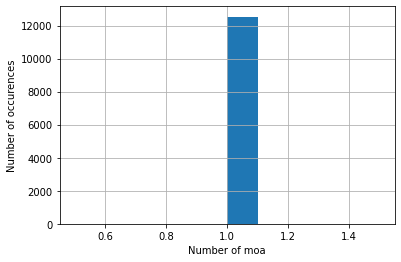

In [18]:
# n_moa post-selection
get_plot_n_moa(n_moa_labels);

In [20]:
temp = (np.argmax(df_lab.drop(columns=['id', 'dtype']).to_numpy(), axis=0))
temp
# np.argmax(train_labels, axis=1)

array([ 34,  32, 166,  37, 188, 122,   1,  76,   3,  21,   7, 172,  45,
        24,  68, 108,  14,  42,   9,  23,  41, 103,  26,  46,  11,  22,
        27,  35,  73])

In [21]:
# these are our labels
moa_label_names = pd.Series(list(df_lab.drop(columns=['id', 'dtype']).columns))
moa_label_names.values

array(['acetylcholine_receptor_agonist',
       'acetylcholine_receptor_antagonist', 'adrenergic_receptor_agonist',
       'adrenergic_receptor_antagonist',
       'bacterial_cell_wall_synthesis_inhibitor',
       'bacterial_dna_inhibitor', 'calcium_channel_blocker',
       'cc_chemokine_receptor_antagonist', 'cdk_inhibitor',
       'cyclooxygenase_inhibitor', 'dna_inhibitor',
       'dopamine_receptor_agonist', 'dopamine_receptor_antagonist',
       'egfr_inhibitor', 'estrogen_receptor_agonist',
       'gaba_receptor_antagonist', 'glucocorticoid_receptor_agonist',
       'glutamate_receptor_antagonist', 'hdac_inhibitor',
       'histamine_receptor_antagonist', 'hmgcr_inhibitor',
       'phosphodiesterase_inhibitor', 'pi3k_inhibitor', 'raf_inhibitor',
       'serotonin_receptor_agonist', 'serotonin_receptor_antagonist',
       'sodium_channel_inhibitor', 'topoisomerase_inhibitor',
       'tubulin_inhibitor'], dtype=object)

In [22]:
# check how many labels we have, and their counts
np.unique(train_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 array([2959,  149,  124,  165,   87,   59,  127,   47,  169,  184,  159,
          47,  152,  147,   62,   70,  108,  164,   53,  121,  134,  109,
          47,  103,  115,  148,  128,   48,  141]))

In [23]:
# showing that the split worked
df_lab['dtype'].value_counts()

train    6126
test     5278
val      1128
Name: dtype, dtype: int64

In [24]:
# dimensions of test/train/val data
print(f'Train, test, val labels {(train_labels.shape, test_labels.shape, val_labels.shape)}')
print(f'Train, test, val features {(train_features.shape, test_features.shape, val_features.shape)}')

Train, test, val labels ((6126,), (5278,), (1128,))
Train, test, val features ((6126, 876), (5278, 876), (1128, 876))


In [25]:
# get ordinal labels
ordinal_labels = get_labels_ordinal(df_lab)
ordinal_labels_full = get_labels_ordinal(df_labels)

Text(0, 0.5, '# Labels')

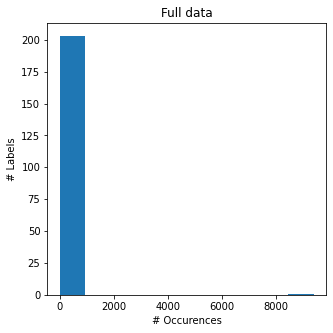

In [33]:
fig, ax1 = plt.subplots(figsize=(5, 5), sharex=True)
ax1.hist(np.unique(ordinal_labels_full, return_counts=True)[1], bins=10)
ax1.set_title('Full data')
ax1.set_xlabel('# Occurences')
ax1.set_ylabel('# Labels')

Text(0, 0.5, '# Labels')

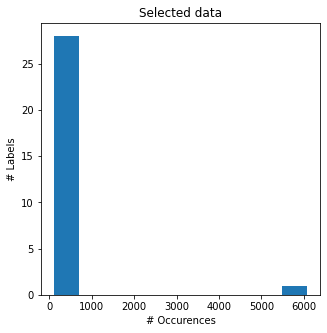

In [34]:
ig, ax2 = plt.subplots(figsize=(5, 5), sharex=True)
ax2.set_title('Selected data')
ax2.hist(np.unique(ordinal_labels, return_counts=True)[1], bins=10)
ax2.set_xlabel('# Occurences')
ax2.set_ylabel('# Labels')

## Data Visualization

In [43]:
# remove all columns except those starting with a g or with a c
npbio_feat = get_c_g_features(df_feat, in_numpy=True)

In [44]:
# remove all columns except those starting with a g 
npgene_exp_feat = get_gene_exp_features(df_feat, in_numpy=True)
# get moas of ordinal labels
name_labels = list(moa_label_names[ordinal_labels.astype(int)].values)

In [45]:
(npbio_feat.shape, npgene_exp_feat.shape)

((12532, 872), (12532, 772))

PHATE on gene expression only

In [46]:
# https://www.nature.com/articles/s41587-019-0336-3
phate_op = phate.PHATE()
genex_phate = phate_op.fit_transform(npgene_exp_feat)

Calculating PHATE...
  Running PHATE on 12532 observations and 772 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.93 seconds.
    Calculating KNN search...
    Calculated KNN search in 22.49 seconds.
    Calculating affinities...
    Calculated affinities in 3.04 seconds.
  Calculated graph and diffusion operator in 27.50 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.58 seconds.
    Calculating KMeans...
    Calculated KMeans in 34.95 seconds.
  Calculated landmark operator in 38.99 seconds.
  Calculating optimal t...
    Automatically selected t = 40
  Calculated optimal t in 4.27 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.55 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.26 seconds.
Calculated PHATE in 80.62 seconds.


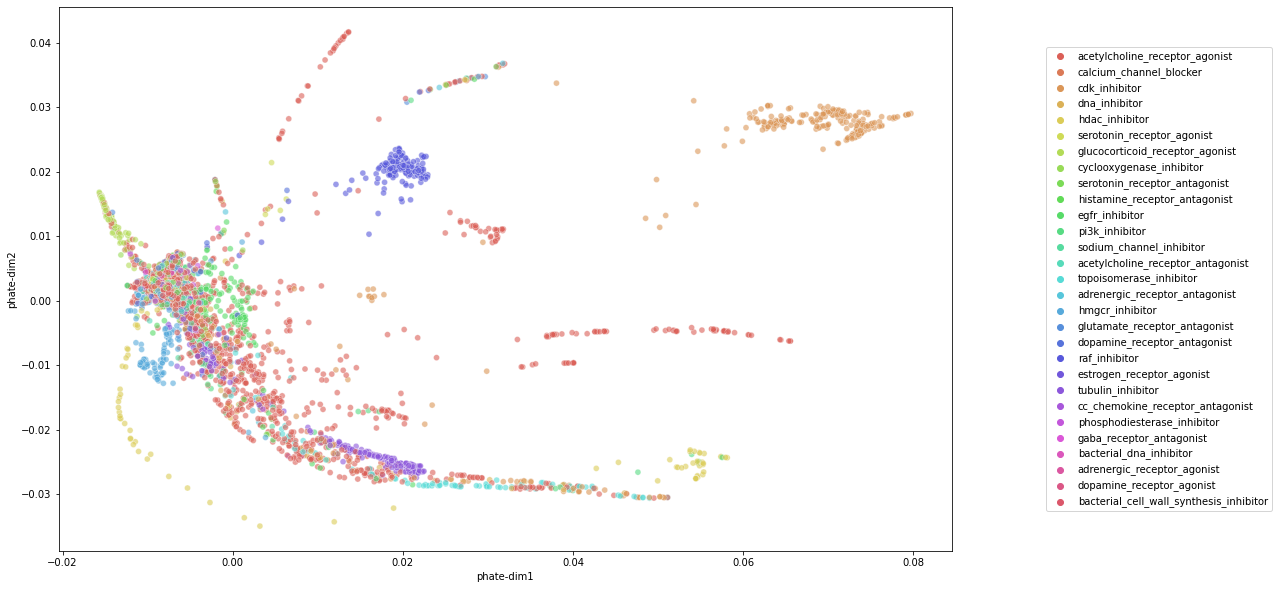

In [47]:
phate_df = pd.DataFrame()
phate_df['MOAs'] = name_labels
phate_df['phate-dim1'] = genex_phate[:,0]
phate_df['phate-dim2'] = genex_phate[:,1]

plt.figure(figsize=(16,10))
plot_phate1 = sns.scatterplot(
    x="phate-dim1", y="phate-dim2",
    hue="MOAs",
    palette=sns.color_palette("hls", np.unique(train_labels)[-1]+1),
    data=phate_df,
    legend="full",
    alpha=0.6
)
plot_phate1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)

<Figure size 1152x720 with 0 Axes>

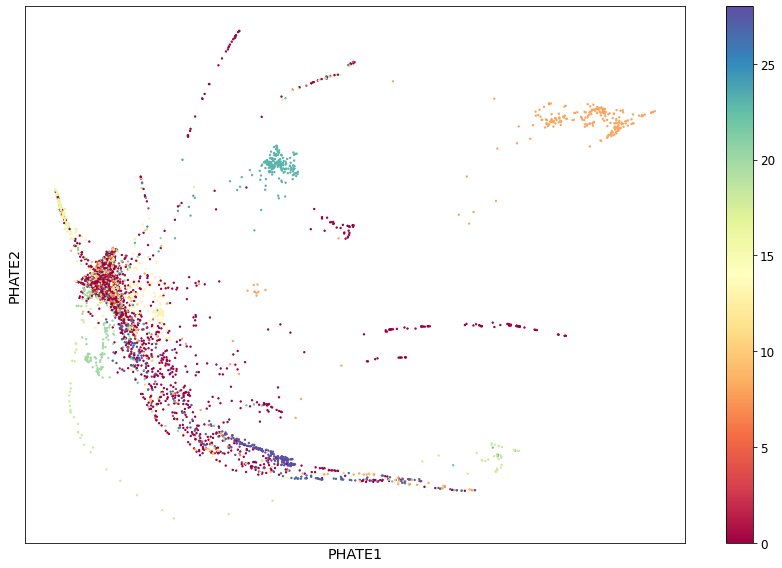

In [48]:
plt.figure(figsize=(16,10))
plot_phate2 = scprep.plot.scatter2d(genex_phate, c=ordinal_labels, figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

PHATE on all c or g data

In [49]:
phate_op = phate.PHATE()
bio_phate = phate_op.fit_transform(npbio_feat)

Calculating PHATE...
  Running PHATE on 12532 observations and 872 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.07 seconds.
    Calculating KNN search...
    Calculated KNN search in 23.29 seconds.
    Calculating affinities...
    Calculated affinities in 4.65 seconds.
  Calculated graph and diffusion operator in 30.11 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.54 seconds.
    Calculating KMeans...
    Calculated KMeans in 25.93 seconds.
  Calculated landmark operator in 29.98 seconds.
  Calculating optimal t...
    Automatically selected t = 32
  Calculated optimal t in 4.93 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.42 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 8.27 seconds.
Calculated PHATE in 75.74 seconds.


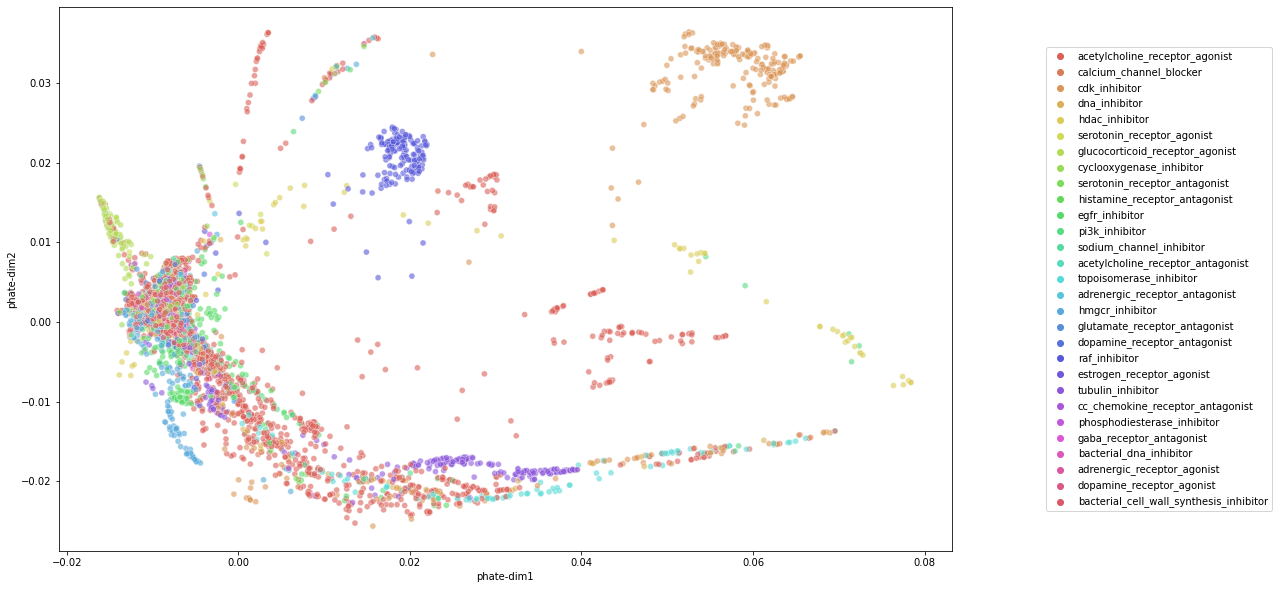

In [50]:
phate_df = pd.DataFrame()
phate_df['MOAs'] = name_labels
phate_df['phate-dim1'] = bio_phate[:,0]
phate_df['phate-dim2'] = bio_phate[:,1]

plt.figure(figsize=(16,10))
plot_phate3 = sns.scatterplot(
    x="phate-dim1", y="phate-dim2",
    hue="MOAs",
    palette=sns.color_palette("hls", np.unique(train_labels)[-1]+1),
    data=phate_df,
    legend="full",
    alpha=0.6
)
plot_phate3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)

In [51]:
# t-SNE
tsne = TSNE(verbose = 2)
genex_tsne = tsne.fit_transform(npgene_exp_feat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12532 samples in 0.009s...
[t-SNE] Computed neighbors for 12532 samples in 11.291s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12532
[t-SNE] Computed conditional probabilities for sample 2000 / 12532
[t-SNE] Computed conditional probabilities for sample 3000 / 12532
[t-SNE] Computed conditional probabilities for sample 4000 / 12532
[t-SNE] Computed conditional probabilities for sample 5000 / 12532
[t-SNE] Computed conditional probabilities for sample 6000 / 12532
[t-SNE] Computed conditional probabilities for sample 7000 / 12532
[t-SNE] Computed conditional probabilities for sample 8000 / 12532
[t-SNE] Computed conditional probabilities for sample 9000 / 12532
[t-SNE] Computed conditional probabilities for sample 10000 / 12532
[t-SNE] Computed conditional probabilities for sample 11000 / 12532
[t-SNE] Computed conditional probabilities for sample 12000 / 12532
[t-SNE] Computed conditional probabilities for sa

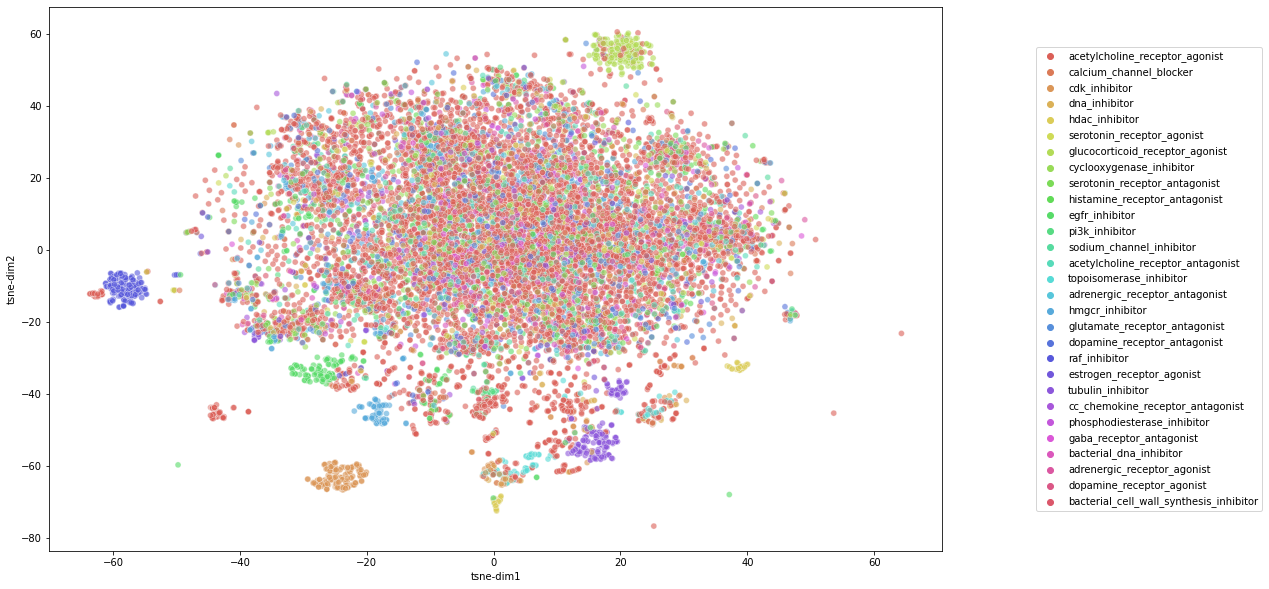

In [52]:
# Plot lower-dimensional representations of samples, colored by family_accession
tsne_df = pd.DataFrame()
tsne_df['y'] = name_labels
tsne_df['tsne-dim1'] = genex_tsne[:,0]
tsne_df['tsne-dim2'] = genex_tsne[:,1]
plt.figure(figsize=(16,10))
plot_tsne1 = sns.scatterplot(
    x="tsne-dim1", y="tsne-dim2",
    hue="y",
    palette=sns.color_palette("hls", np.unique(train_labels)[-1]+1),
    data=tsne_df,
    legend="full",
    alpha=0.6
)
plot_tsne1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)

In [53]:
# t-SNE
tsne = TSNE(verbose = 2)
bio_tsne = tsne.fit_transform(npbio_feat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12532 samples in 0.009s...
[t-SNE] Computed neighbors for 12532 samples in 10.628s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12532
[t-SNE] Computed conditional probabilities for sample 2000 / 12532
[t-SNE] Computed conditional probabilities for sample 3000 / 12532
[t-SNE] Computed conditional probabilities for sample 4000 / 12532
[t-SNE] Computed conditional probabilities for sample 5000 / 12532
[t-SNE] Computed conditional probabilities for sample 6000 / 12532
[t-SNE] Computed conditional probabilities for sample 7000 / 12532
[t-SNE] Computed conditional probabilities for sample 8000 / 12532
[t-SNE] Computed conditional probabilities for sample 9000 / 12532
[t-SNE] Computed conditional probabilities for sample 10000 / 12532
[t-SNE] Computed conditional probabilities for sample 11000 / 12532
[t-SNE] Computed conditional probabilities for sample 12000 / 12532
[t-SNE] Computed conditional probabilities for sa

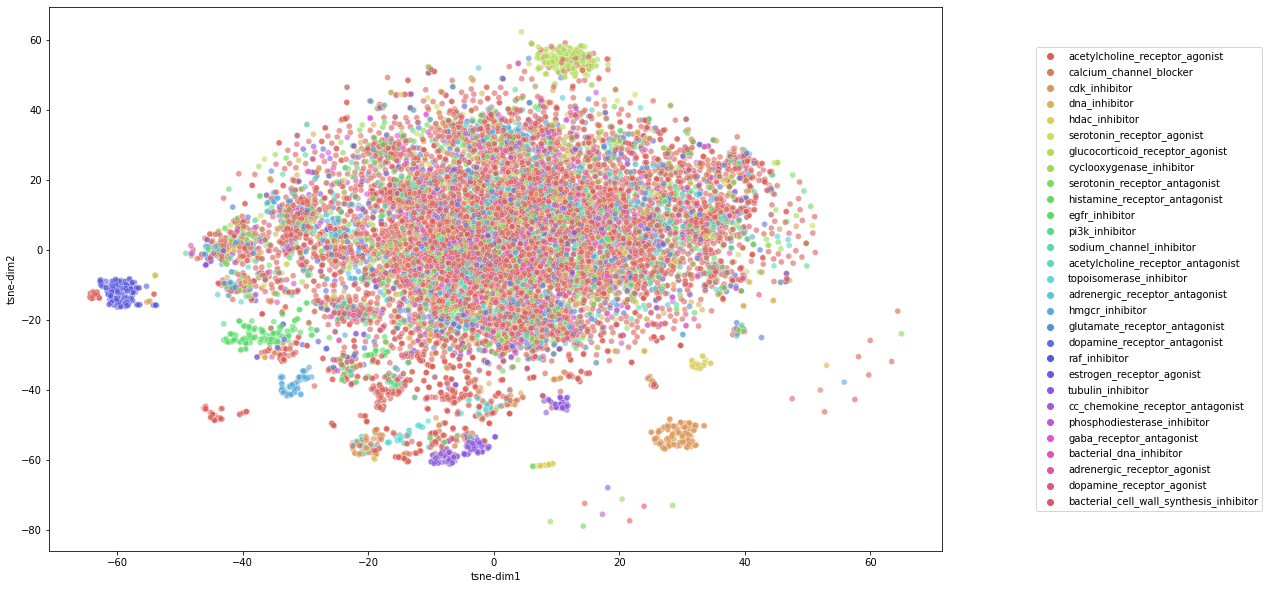

In [54]:
# Plot lower-dimensional representations of samples, colored by family_accession
tsne_df = pd.DataFrame()
tsne_df['y'] = name_labels
tsne_df['tsne-dim1'] = bio_tsne[:,0]
tsne_df['tsne-dim2'] = bio_tsne[:,1]
plt.figure(figsize=(16,10))
plot_tsne1 = sns.scatterplot(
    x="tsne-dim1", y="tsne-dim2",
    hue="y",
    palette=sns.color_palette("hls", np.unique(train_labels)[-1]+1),
    data=tsne_df,
    legend="full",
    alpha=0.6
)
plot_tsne1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)

Split PHATE and t-SNE data into test/train/val

(same split as regular data)

In [55]:
# create df for phate results
df_phate = pd.DataFrame(bio_phate)
df_phate['labels'] = ordinal_labels
df_phate['dtype'] = n_moa_feature.dtype

# create df for tsne results
df_tsne =  pd.DataFrame(bio_tsne)
df_tsne['labels'] = ordinal_labels
df_tsne['dtype'] = n_moa_feature.dtype

# get split tsne data (including labels) in pandas DataFrame
train_tsne, test_tsne, val_tsne = split_data_train_test_val(df_tsne, in_numpy=False)

# get split tsne data (including labels) in pandas DataFrame
train_phate, test_phate, val_phate = split_data_train_test_val(df_phate, in_numpy=False)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [62]:
# for autogluon, we don't need to separate test and val
# so, join two
test_val_tsne = pd.concat([test_tsne, val_tsne])
test_val_phate = pd.concat([test_phate, val_phate])

In [56]:
# dimensions of test/train/val data
print(f'Train, test, val t-SNE {(train_tsne.shape, test_tsne.shape, val_tsne.shape)}')
print(f'Train, test, val PHATE {(train_phate.shape, test_phate.shape, val_phate.shape)}')

Train, test, val t-SNE ((6126, 3), (5278, 3), (1128, 3))
Train, test, val PHATE ((6126, 3), (5278, 3), (1128, 3))


In [57]:
train_tsne.head()

,0,1,labels
0,-29.955814,13.668681,17
1,4.642434,-0.655911,0
2,-1.433404,37.420937,11
3,40.342697,16.830095,0
4,8.778000,-61.322861,18


In [58]:
train_phate.head()

,0,1,labels
0,-0.010011,0.002711,17
1,-0.008434,0.001027,0
2,-0.011064,0.002679,11
3,-0.010774,0.001092,0
4,0.051925,0.009240,18


## Prediction model
### 1. Autogluon
### 2. Neural Network
* 1 to 4 convolutional neural network (CNN) layers
* 1 to 2 bidirectional recurrent neural network (RNN) layers
* 1 to 2 fully connected (FC) layers, in a global architecture layout CNN-RNN-FC

All Data

# IGNORE THIS HORRIBLE VARIABLE NAME
(`train_val`)
# NEED TO CHANGE IT BEFORE SUBMISSION
`train_val` to just `train_...`

In [65]:
temp1 = train_features
temp1['labels'] = train_labels
temp2 = val_features
temp2['labels'] = val_labels
train_val_data = pd.concat([temp1, temp2])

In [83]:
temp_label_counts = np.unique(train_val_data['labels'].values, return_counts=True)[1]
print(f'Range of label counts: min = {temp_label_counts[-1]}, max = {temp_label_counts[0]}')

Range of label counts: min = 167, max = 3523


Range of label counts: min = 167, max = 3523


Text(0, 0.5, '# Labels')

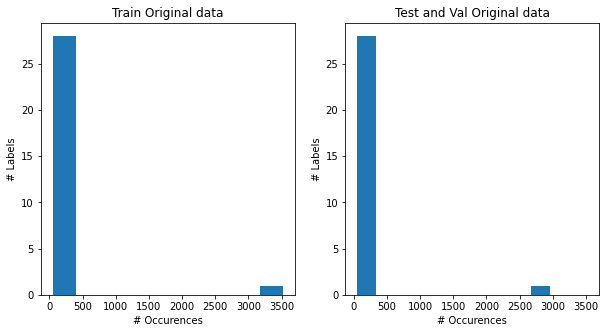

In [161]:
temp_label_counts = np.unique(train_val_data['labels'].values, return_counts=True)[1]
print(f'Range of label counts: min = {temp_label_counts[-1]}, max = {temp_label_counts[0]}')
fig, (ax1_, ax2_) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax1_.hist(temp_label_counts, bins=10)
ax1_.set_title('Train Original data')
ax1_.set_xlabel('# Occurences')
ax1_.set_ylabel('# Labels')

ax2_.hist(np.unique(train_tsne['labels'].values, return_counts=True)[1], bins=10)
ax2_.set_title('Test and Val Original data')
ax2_.set_xlabel('# Occurences')
ax2_.set_ylabel('# Labels')

In [67]:
save_path = 'autogluon_model'  # specifies folder to store trained models
predictor = TabularPredictor(label='labels', path=DATA/save_path).fit(train_val_data)

	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "/gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project/autogluon_model/"
AutoGluon Version:  0.3.1
Train Data Rows:    7254
Train Data Columns: 877
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	First 10 (of 29) unique label values:  [17, 0, 11, 18, 9, 15, 3, 10, 19, 12]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 29
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Mem

In [68]:
predictor = TabularPredictor.load(save_path)
y_pred = predictor.predict(train_val_data.drop(columns='labels'))
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=train_val_data['labels'], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.9988971601874828
Evaluations on test data:
{
    "accuracy": 0.9988971601874828,
    "balanced_accuracy": 0.9977852369304228,
    "mcc": 0.9985361933954977
}


Predictions:  
 0       17
1        0
2       11
3        0
4       18
        ..
1123     0
1124     0
1125     0
1126     6
1127    17
Name: labels, Length: 7254, dtype: int64


In [73]:
autogluon_accuracies = predictor.leaderboard()
autogluon_accuracies = autogluon_accuracies.rename(columns={'score_val':'accuracy_val'})
autogluon_accuracies

                  model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.997245       0.457079  2818.764307                0.002862           0.672512            2       True         13
1              CatBoost   0.990358       0.055911  2168.637975                0.055911        2168.637975            1       True          8
2       NeuralNetFastAI   0.971074       0.309232    27.714371                0.309232          27.714371            1       True          3
3              LightGBM   0.954545       0.243737   599.722890                0.243737         599.722890            1       True          5
4               XGBoost   0.951791       0.089074   621.739449                0.089074         621.739449            1       True         11
5         LightGBMLarge   0.950413       0.649085  1894.998363                0.649085        1894.998363            1       True         12
6            

,model,accuracy_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.997245,0.457079,2818.764307,0.002862,0.672512,2,True,13
1,CatBoost,0.990358,0.055911,2168.637975,0.055911,2168.637975,1,True,8
2,NeuralNetFastAI,0.971074,0.309232,27.714371,0.309232,27.714371,1,True,3
3,LightGBM,0.954545,0.243737,599.722890,0.243737,599.722890,1,True,5
4,XGBoost,0.951791,0.089074,621.739449,0.089074,621.739449,1,True,11
5,LightGBMLarge,0.950413,0.649085,1894.998363,0.649085,1894.998363,1,True,12
6,LightGBMXT,0.896694,0.603696,606.153201,0.603696,606.153201,1,True,4
7,KNeighborsUnif,0.608815,0.500135,0.522425,0.500135,0.522425,1,True,1
8,KNeighborsDist,0.606061,0.499529,0.507426,0.499529,0.507426,1,True,2
9,RandomForestGini,0.592287,0.210967,117.438373,0.210967,117.438373,1,True,6


#### Plot confusion matrix for Autogluon

In [135]:
name_labels1 = list(moa_label_names[train_val_data['labels'].astype(int)].values)

In [137]:
# get confusion matrix for predictions
cm = confusion_matrix(train_val_data['labels'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=name_labels1)

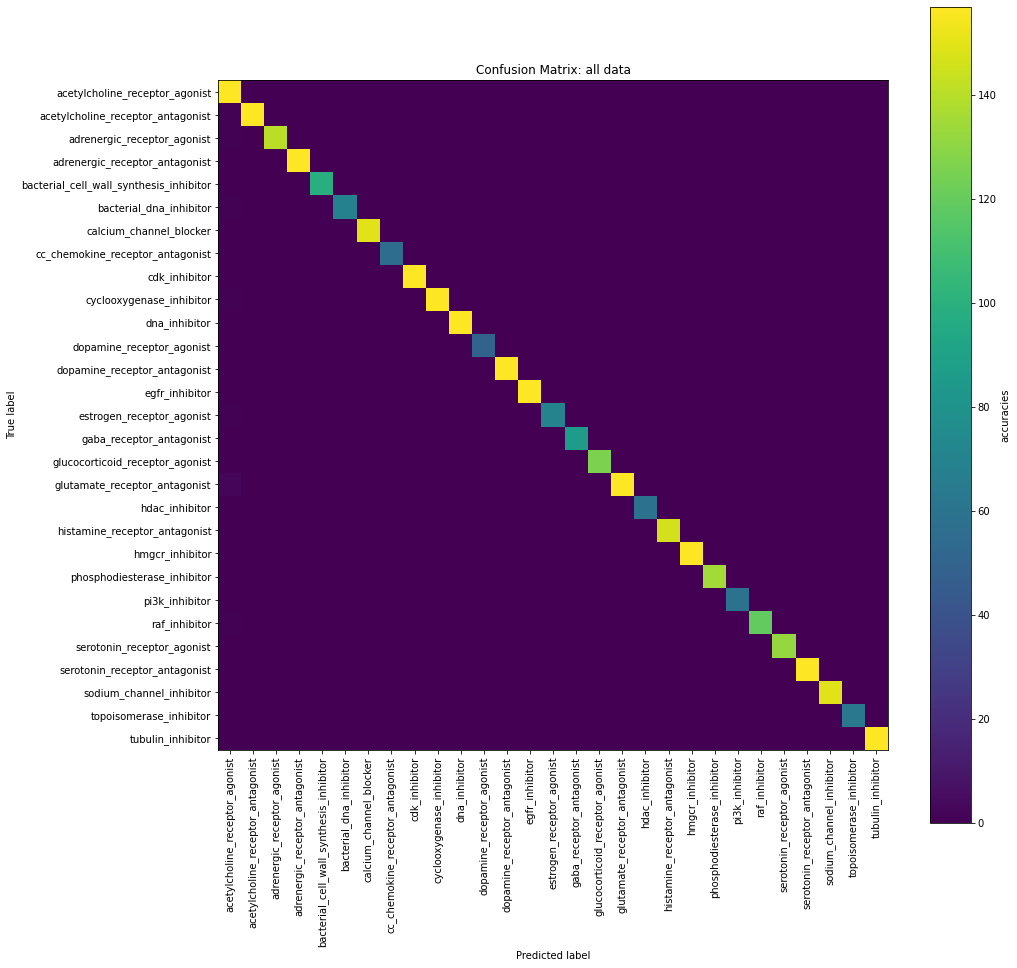

In [143]:
accuracies = cm#/cm.sum(1)
fig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
shw = ax.imshow(accuracies, cmap='viridis')
ax.set_title('Confusion Matrix: all data')

bar = plt.colorbar(shw)
  
# show plot with labels
plt.xlabel('Predicted label')
plt.ylabel('True label')
bar.set_label('accuracies')
plt.xticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names, rotation='vertical')
plt.yticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names)

shw.set_clim(0, temp_label_counts[-1])
plt.show()

Text(0.5, 1.0, 'Confusion Matrix: all data')

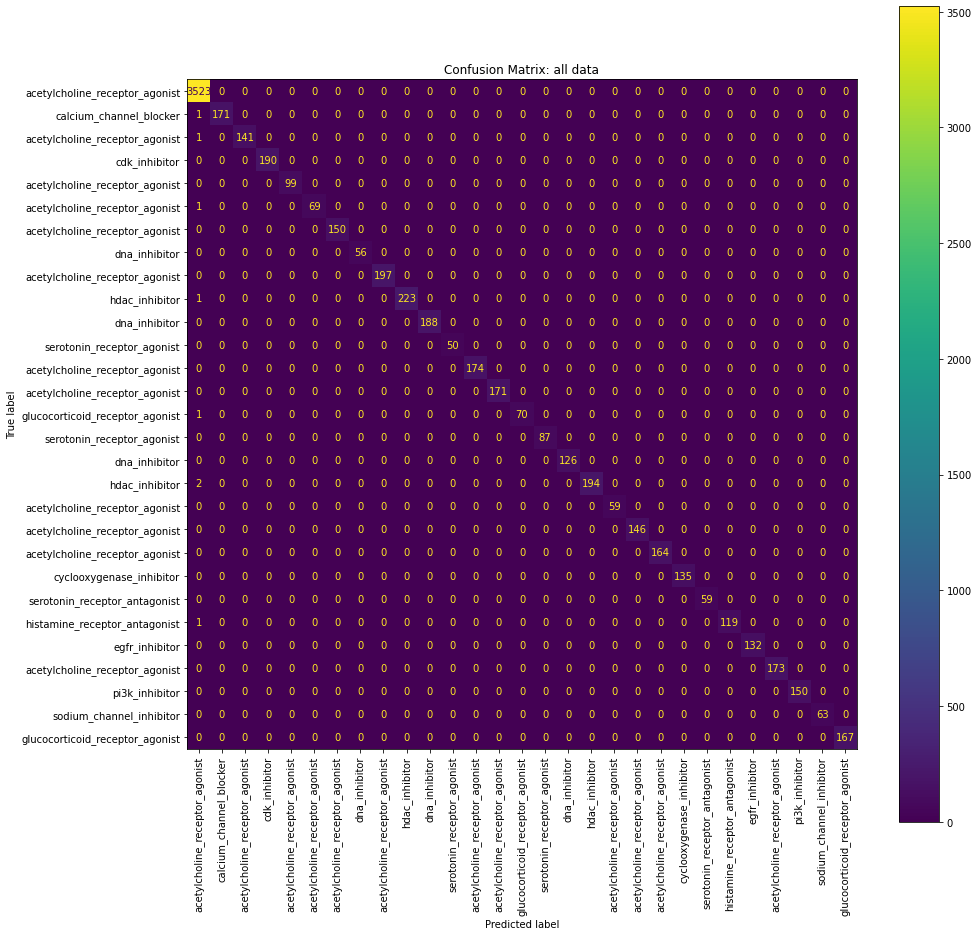

In [103]:
# ConfusionMatrixDisplay(pd.Series(test_labels), y_pred)
fig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
disp1 = disp.plot(ax=ax, xticks_rotation='vertical')
ax.set_title('Confusion Matrix: all data')

Text(0.5, 1.0, 'Confusion Matrix: all data')

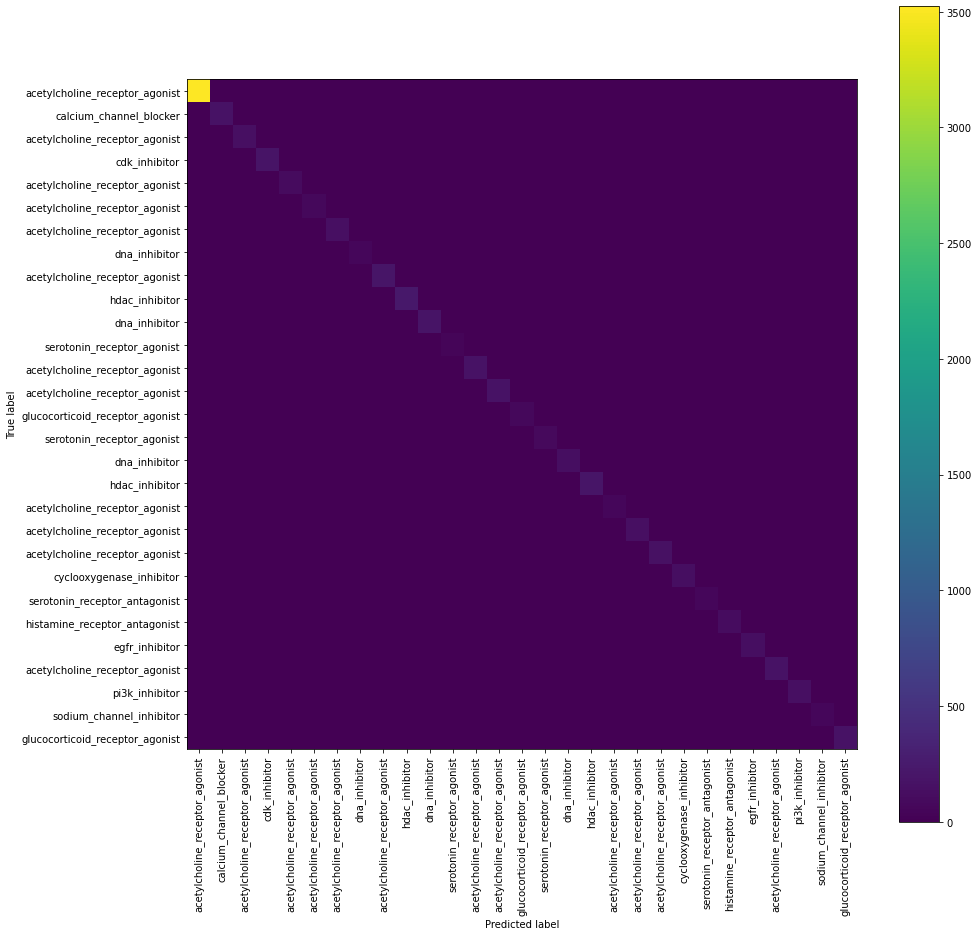

In [104]:
# plot confusion matrix
ig, ax2 = plt.subplots(figsize=(15, 15))
disp2 = disp.plot(include_values=False, ax=ax2, xticks_rotation = 'vertical')
ax.set_title('Confusion Matrix: all data')

### Autogluon with t-sne

Range of label counts: min = 157, max = 3126


Text(0, 0.5, '# Labels')

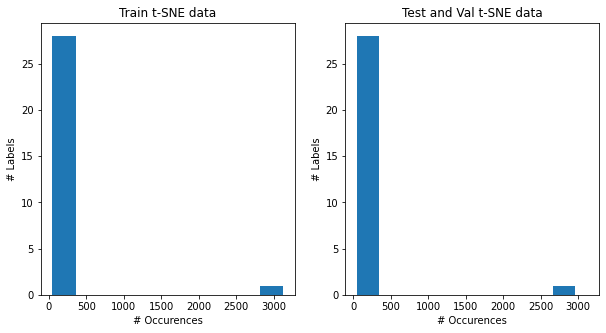

In [160]:
temp_label_counts = np.unique(test_val_tsne['labels'].values, return_counts=True)[1]
print(f'Range of label counts: min = {temp_label_counts[-1]}, max = {temp_label_counts[0]}')
fig, (ax1_, ax2_) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax1_.hist(temp_label_counts, bins=10)
ax1_.set_title('Train t-SNE data')
ax1_.set_xlabel('# Occurences')
ax1_.set_ylabel('# Labels')

ax2_.hist(np.unique(train_tsne['labels'].values, return_counts=True)[1], bins=10)
ax2_.set_title('Test and Val t-SNE data')
ax2_.set_xlabel('# Occurences')
ax2_.set_ylabel('# Labels')

In [107]:
save_path2 = 'tsne_autogluon_model'  # specifies folder to store trained models
predictor2 = TabularPredictor(label='labels', path=DATA/save_path2).fit(test_val_tsne)

Beginning AutoGluon training ...
AutoGluon will save models to "/gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project/tsne_autogluon_model/"
AutoGluon Version:  0.3.1
Train Data Rows:    6406
Train Data Columns: 2
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	First 10 (of 29) unique label values:  [0, 6, 8, 10, 18, 16, 24, 9, 25, 19]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 29
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    7614.36 MB
	Train Data (Original)  Memory Usage: 0.05 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually

In [108]:
predictor2 = TabularPredictor.load(save_path2)
y_pred2 = predictor2.predict(test_val_tsne.drop(columns=['labels']))
print("Predictions:  \n", y_pred2)
perf = predictor2.evaluate_predictions(y_true=test_val_tsne['labels'], y_pred=y_pred2, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.6300343428036216
Evaluations on test data:
{
    "accuracy": 0.6300343428036216,
    "balanced_accuracy": 0.3071354900124039,
    "mcc": 0.46473774828794684
}


Predictions:  
 0       0
1       0
2       0
3       8
4       0
       ..
1123    0
1124    0
1125    0
1126    0
1127    0
Name: labels, Length: 6406, dtype: int64


In [109]:
tsne_autogluon_accuracies = predictor2.leaderboard()
tsne_autogluon_accuracies = tsne_autogluon_accuracies.rename(columns={'score_val':'accuracy_val'})
tsne_autogluon_accuracies

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.575663       1.048955  73.233252                0.000981           0.921580            2       True         13
1              LightGBM   0.564743       0.025659   5.537528                0.025659           5.537528            1       True          5
2         LightGBMLarge   0.563183       0.025512  14.022789                0.025512          14.022789            1       True         12
3               XGBoost   0.563183       0.029500   6.558862                0.029500           6.558862            1       True         11
4            LightGBMXT   0.563183       0.240415  33.520364                0.240415          33.520364            1       True          4
5       NeuralNetFastAI   0.560062       0.031279  18.919130                0.031279          18.919130            1       True          3
6              CatBoost   0

,model,accuracy_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.575663,1.048955,73.233252,0.000981,0.921580,2,True,13
1,LightGBM,0.564743,0.025659,5.537528,0.025659,5.537528,1,True,5
2,LightGBMLarge,0.563183,0.025512,14.022789,0.025512,14.022789,1,True,12
3,XGBoost,0.563183,0.029500,6.558862,0.029500,6.558862,1,True,11
4,LightGBMXT,0.563183,0.240415,33.520364,0.240415,33.520364,1,True,4
5,NeuralNetFastAI,0.560062,0.031279,18.919130,0.031279,18.919130,1,True,3
6,CatBoost,0.556942,0.009841,5.787583,0.009841,5.787583,1,True,8
7,KNeighborsUnif,0.550702,0.109074,0.012878,0.109074,0.012878,1,True,1
8,ExtraTreesGini,0.533541,0.202991,1.658499,0.202991,1.658499,1,True,9
9,ExtraTreesEntr,0.533541,0.204728,2.439578,0.204728,2.439578,1,True,10


In [145]:
name_labels1 = list(moa_label_names[test_val_tsne['labels'].astype(int)].values)

In [148]:
# get confusion matrix for predictions
cm2 = confusion_matrix(test_val_tsne['labels'], y_pred2)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm2,
                              display_labels=name_labels1)

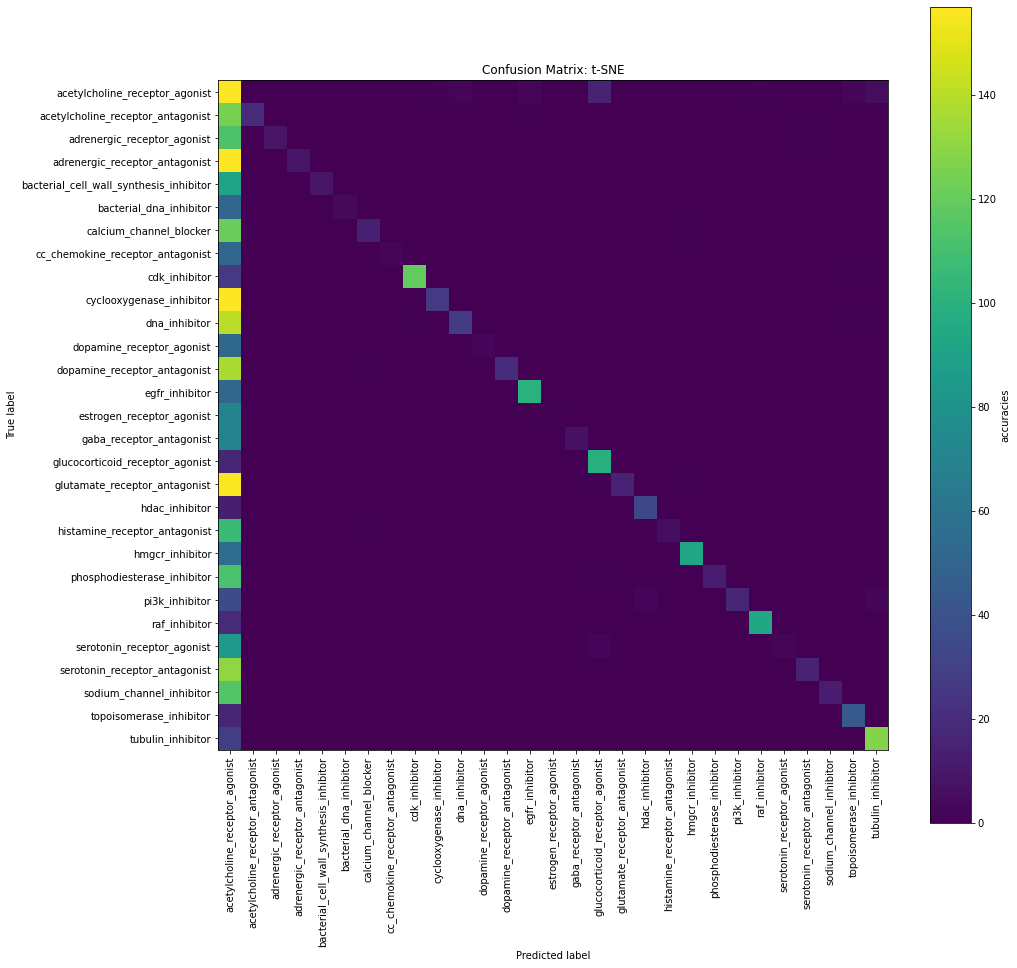

In [149]:
accuracies = cm2#/cm.sum(1)
fig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
shw = ax.imshow(accuracies, cmap='viridis')
ax.set_title('Confusion Matrix: t-SNE')

bar = plt.colorbar(shw)
  
# show plot with labels
plt.xlabel('Predicted label')
plt.ylabel('True label')
bar.set_label('accuracies')
plt.xticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names, rotation='vertical')
plt.yticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names)

shw.set_clim(0, temp_label_counts[-1])
plt.show()

Text(0.5, 1.0, 'Confusion Matrix: t-SNE data')

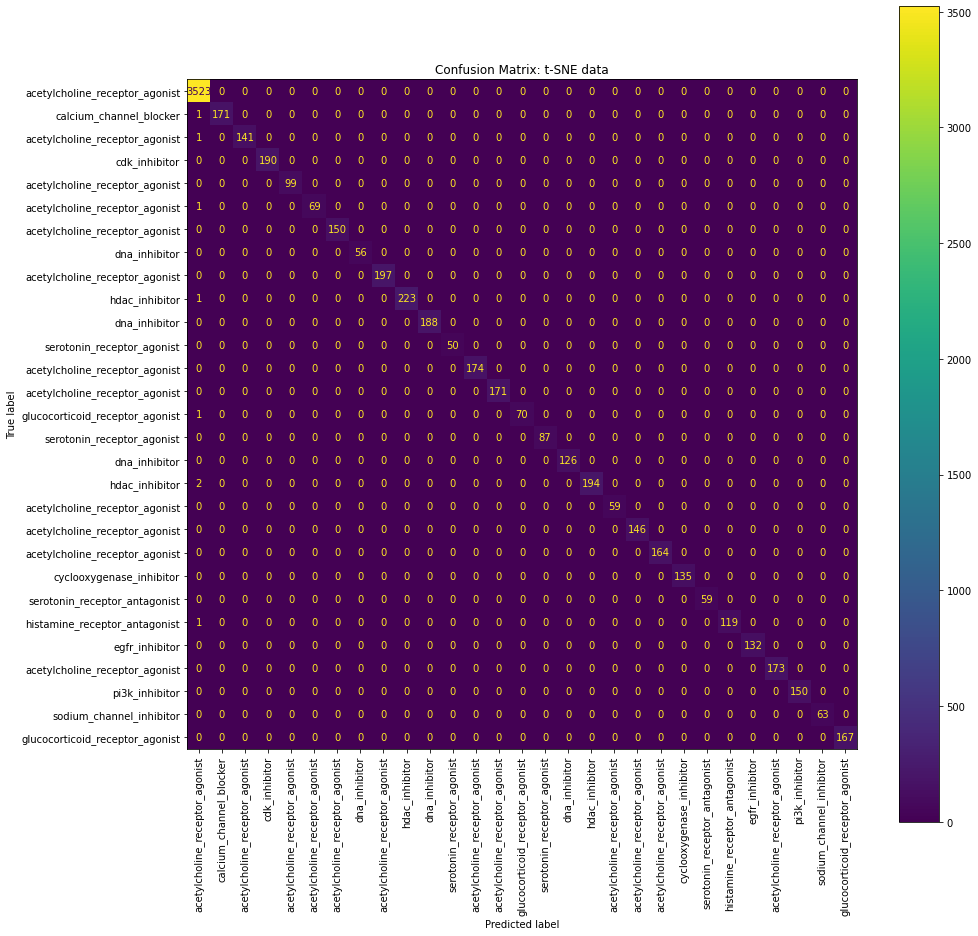

In [111]:
# ConfusionMatrixDisplay(pd.Series(test_labels), y_pred)
ig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
disp1 = disp.plot(ax=ax, xticks_rotation = 'vertical')
ax.set_title('Confusion Matrix: t-SNE data')

Text(0.5, 1.0, 'Confusion Matrix: t-SNE data')

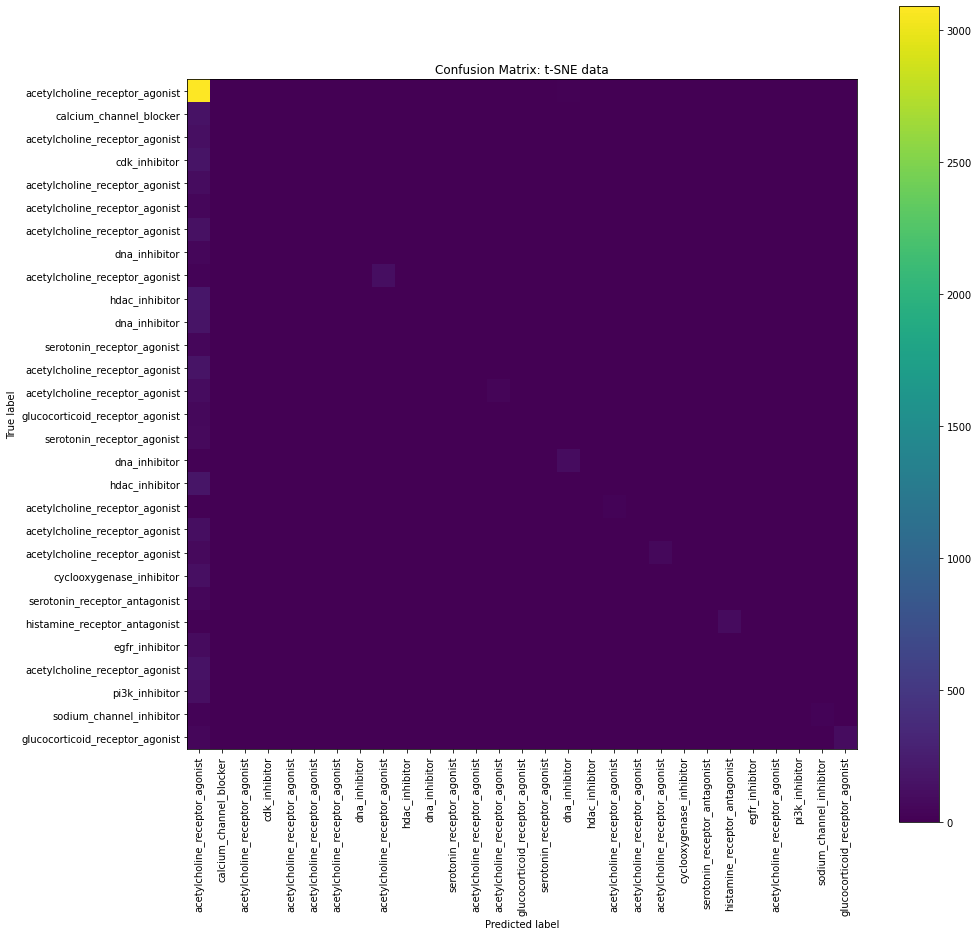

In [120]:
# plot confusion matrix
ig, ax2 = plt.subplots(figsize=(15, 15))
disp2 = disp.plot(include_values=False, ax=ax2, xticks_rotation = 'vertical')
ax2.set_title('Confusion Matrix: t-SNE data')

### Autogluon with PHATE

Range of label counts: min = 157, max = 3126


Text(0, 0.5, '# Labels')

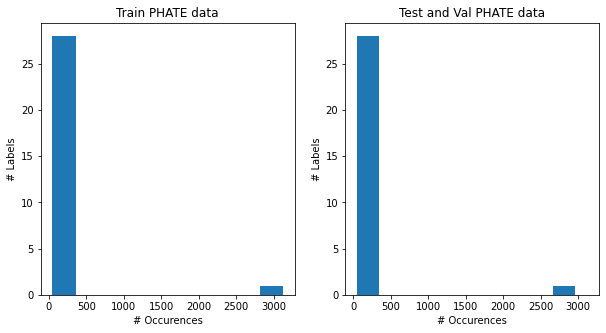

In [159]:
temp_label_counts = np.unique(test_val_phate['labels'].values, return_counts=True)[1]
print(f'Range of label counts: min = {temp_label_counts[-1]}, max = {temp_label_counts[0]}')
fig, (ax1_, ax2_) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax1_.hist(temp_label_counts, bins=10)
ax1_.set_title('Train PHATE data')
ax1_.set_xlabel('# Occurences')
ax1_.set_ylabel('# Labels')

ax2_.hist(np.unique(train_phate['labels'].values, return_counts=True)[1], bins=10)
ax2_.set_title('Test and Val PHATE data')
ax2_.set_xlabel('# Occurences')
ax2_.set_ylabel('# Labels')

In [113]:
save_path3 = 'phate_autogluon_model'  # specifies folder to store trained models
predictor3 = TabularPredictor(label='labels', path=DATA/save_path3).fit(test_val_phate)

Beginning AutoGluon training ...
AutoGluon will save models to "/gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project/phate_autogluon_model/"
AutoGluon Version:  0.3.1
Train Data Rows:    6406
Train Data Columns: 2
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	First 10 (of 29) unique label values:  [0, 6, 8, 10, 18, 16, 24, 9, 25, 19]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 29
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    7322.92 MB
	Train Data (Original)  Memory Usage: 0.1 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually

In [114]:
predictor3 = TabularPredictor.load(save_path3)
y_pred3 = predictor3.predict(test_val_phate.drop(columns=['labels']))
print("Predictions:  \n", y_pred3)
perf = predictor3.evaluate_predictions(y_true=test_val_phate['labels'], y_pred=y_pred3, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.5716515766468936
Evaluations on test data:
{
    "accuracy": 0.5716515766468936,
    "balanced_accuracy": 0.20312801315591184,
    "mcc": 0.3471817726265957
}


Predictions:  
 0       0
1       0
2       0
3       8
4       0
       ..
1123    0
1124    0
1125    0
1126    0
1127    0
Name: labels, Length: 6406, dtype: int64


In [115]:
phate_autogluon_accuracies = predictor3.leaderboard()
phate_autogluon_accuracies = phate_autogluon_accuracies.rename(columns={'score_val':'accuracy_val'})
phate_autogluon_accuracies

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.564743       0.243996  18.958103                0.000658           0.609832            2       True         13
1               XGBoost   0.563183       0.020584   5.411705                0.020584           5.411705            1       True         11
2              CatBoost   0.556942       0.023212  19.432676                0.023212          19.432676            1       True          8
3              LightGBM   0.555382       0.013304   7.212991                0.013304           7.212991            1       True          5
4       NeuralNetFastAI   0.552262       0.019787   8.972454                0.019787           8.972454            1       True          3
5         LightGBMLarge   0.549142       0.022480  14.428030                0.022480          14.428030            1       True         12
6            LightGBMXT   0

,model,accuracy_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.564743,0.243996,18.958103,0.000658,0.609832,2,True,13
1,XGBoost,0.563183,0.020584,5.411705,0.020584,5.411705,1,True,11
2,CatBoost,0.556942,0.023212,19.432676,0.023212,19.432676,1,True,8
3,LightGBM,0.555382,0.013304,7.212991,0.013304,7.212991,1,True,5
4,NeuralNetFastAI,0.552262,0.019787,8.972454,0.019787,8.972454,1,True,3
5,LightGBMLarge,0.549142,0.022480,14.428030,0.022480,14.428030,1,True,12
6,LightGBMXT,0.549142,0.381437,46.990908,0.381437,46.990908,1,True,4
7,KNeighborsUnif,0.508580,0.107666,0.019777,0.107666,0.019777,1,True,1
8,ExtraTreesGini,0.503900,0.202725,1.908056,0.202725,1.908056,1,True,9
9,ExtraTreesEntr,0.503900,0.202943,1.961677,0.202943,1.961677,1,True,10


In [150]:
name_labels1 = list(moa_label_names[test_val_phate['labels'].astype(int)].values)

In [154]:
# get confusion matrix for predictions
cm3 = confusion_matrix(test_val_phate['labels'], y_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3,
                              display_labels=name_labels1)

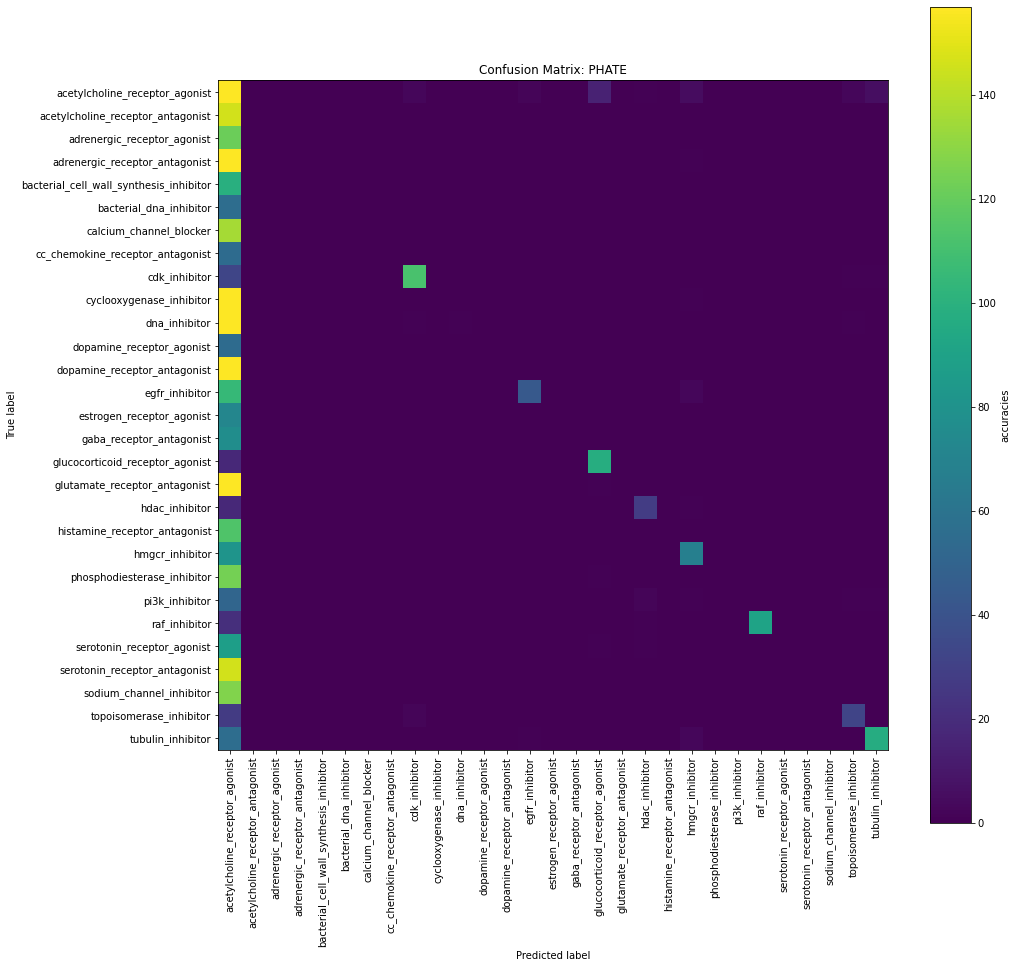

In [156]:
accuracies = cm3#/cm.sum(1)
fig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
shw = ax.imshow(accuracies, cmap='viridis')
ax.set_title('Confusion Matrix: PHATE')

bar = plt.colorbar(shw)
  
# show plot with labels
plt.xlabel('Predicted label')
plt.ylabel('True label')
bar.set_label('accuracies')
plt.xticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names, rotation='vertical')
plt.yticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names)

shw.set_clim(0, temp_label_counts[-1])
plt.show()

Text(0.5, 1.0, 'Confusion Matrix: PHATE data')

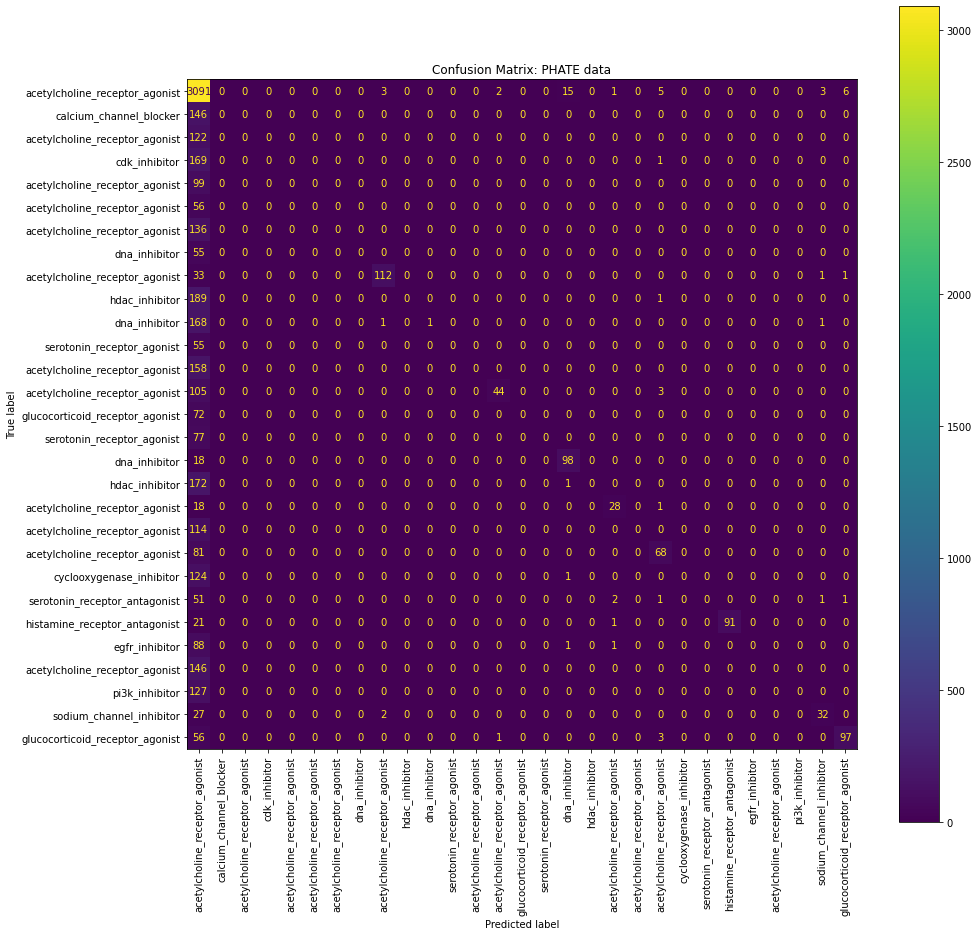

In [118]:
# ConfusionMatrixDisplay(pd.Series(test_labels), y_pred)
ig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
disp1 = disp.plot(ax=ax, xticks_rotation = 'vertical')
ax.set_title('Confusion Matrix: PHATE data')

Text(0.5, 1.0, 'Confusion Matrix: PHATE data')

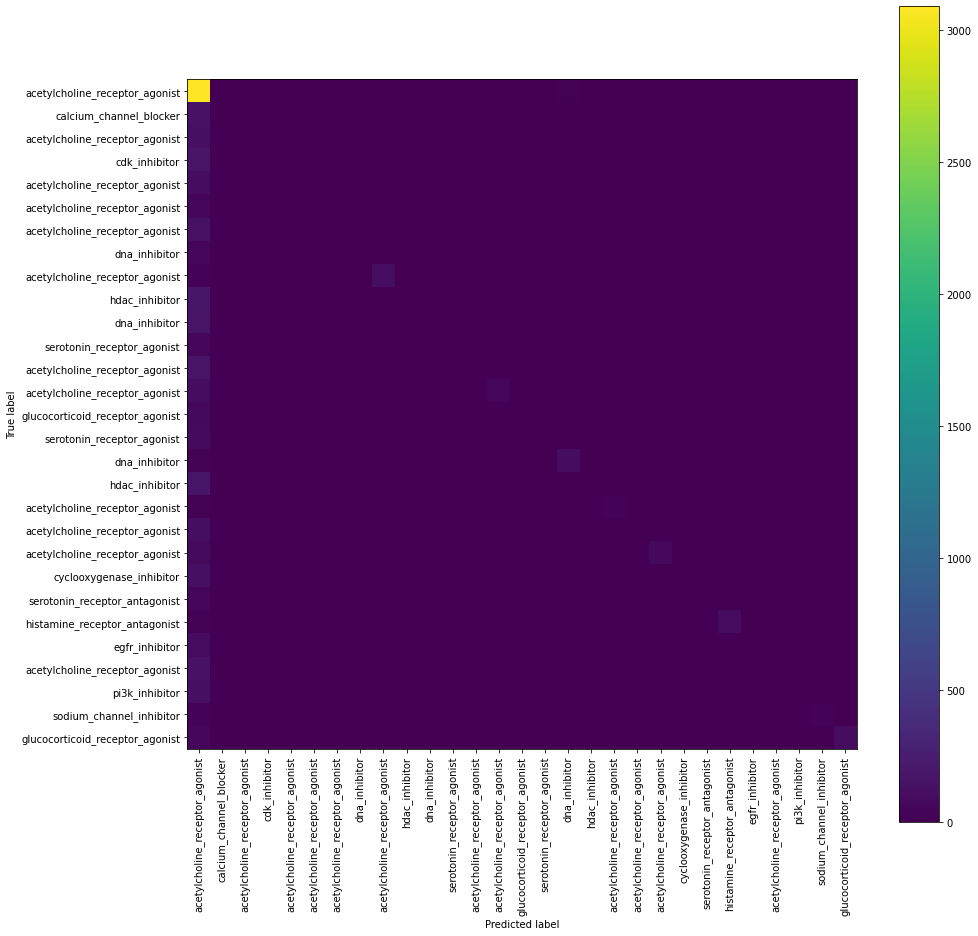

In [119]:
# plot confusion matrix
ig, ax2 = plt.subplots(figsize=(15, 15))
disp2 = disp.plot(include_values=False, ax=ax2, xticks_rotation = 'vertical')
ax.set_title('Confusion Matrix: PHATE data')

### NN all data

In [ ]:
def bi_LSTM(x_train,y_train):
    inputs=Input(shape=(x_train[0].shape), name='inputs')
    
    dense1 = Dense(32, activation='relu')(inputs)
    biLSTM1 = Bidirectional(LSTM(128))(dense1)
    drop1 = Dropout(0.3)(biLSTM1)
    bn1 = BatchNormalization()(drop1)
    dense2 = Dense(64, activation='relu')(bn1)
    drop2 = Dropout(0.3)(dense2)
    bn2 = BatchNormalization()(drop2)
    main_output = Dense(1, activation='softmax')(bn2)

    model = Model(inputs= inputs, outputs=main_output, name='BiLSTM_Model')
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
inputs=Input(shape=(train_features.iloc[0].shape[0]-1, 1), name='inputs')

dense1 = Dense(32, activation='relu')(inputs)
con1 = Conv1D(32, (6), activation='relu', name='conv1d_1')(dense1)
# con2 = Conv1D(32, (6), activation='relu', name='conv1d_1')(con1)
birnn1 = Bidirectional(SimpleRNN(64))(con1)
drop1 = Dropout(0.3)(birnn1)
bn1 = BatchNormalization()(drop1)
dense2 = Dense(32, activation='relu')(bn1)
drop2 = Dropout(0.3)(dense2)
bn2 = BatchNormalization()(drop2)
main_output = Dense(1, activation='softmax')(bn2)

model1 = Model(inputs= inputs, outputs=main_output, name='BiRNN_Model')
model1.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
model1.summary()

Model: "BiRNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 876, 1)]          0         
                                                                 
 dense_3 (Dense)             (None, 876, 32)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 871, 32)           6176      
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              12416     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                       

In [ ]:
# apply early stopping to prevent overfitting, or prevent resource waste if the
# model is really bad
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
# here we need to use the np features because tensorflow accepts them better
# so, we'll use nptrain_features, nptest_features, npval_features
history1 = model1.fit(convert_to_tensor(nptrain_features, dtype=tf.float64), convert_to_tensor(train_labels, dtype=tf.float64),
                      epochs=10, batch_size=64,
                      validation_data=(convert_to_tensor(npval_features, dtype=tf.float64), convert_to_tensor(val_labels, dtype=tf.float64)),
                      callbacks=[es])


Epoch 1/10
59/59 [==============================] - 36s 576ms/step - loss: nan - accuracy: 0.0242 - val_loss: nan - val_accuracy: 0.0246
Epoch 2/10
59/59 [==============================] - 34s 570ms/step - loss: nan - accuracy: 0.0242 - val_loss: nan - val_accuracy: 0.0246
Epoch 3/10
59/59 [==============================] - 34s 569ms/step - loss: nan - accuracy: 0.0242 - val_loss: nan - val_accuracy: 0.0246
Epoch 00003: early stopping


# IGNORE ALL BELOW

In [ ]:
def network(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    
    # START my code
    # convolution layer: 
    #   filters=64, (last dimension of output from this layer)
    #   kernel_size=(6), (2nd dimension of output from this layer is previous layers'-6+1, which means kernel size has to be 6)
    conv1d_1 = Convolution1D(64, (6), activation='relu', name='conv1d_1')(inputs_cnn)
    # batch normalization
    batch_normalization = BatchNormalization(name='batch_normalization')(conv1d_1)
    # max pooling:
    #   pool_size and strides=2, (2nd output dimension from this layer is 1/2 from 2nd dimension of input to this layer)
    #   padding="same" rounds up division of output dimension
    max_pooling1d = MaxPool1D(pool_size=2, strides=2, padding='same', name='max_pooling1d')(batch_normalization)
    # convolution layer: 
    #   filters=128, (last dimension of output from this layer)
    #   kernel_size=(3), (2nd dimension of output from this layer is previous layers'-3+1, which means kernel size has to be 3)
    conv1d_2 = Convolution1D(128, (3), name='conv1d_2')(max_pooling1d)
    # batch normalization
    batch_normalization_1 = BatchNormalization(name='batch_normalization_1')(conv1d_2)
    # max pooling:
    #   pool_size and strides=2, (2nd output dimension from this layer is 1/2 from 2nd dimension of input to this layer)
    #   padding="same" rounds up division of output dimension
    max_pooling1d_1 = MaxPool1D(pool_size=2, strides=2, padding='same', name='max_pooling1d_1')(batch_normalization_1)
    # flattening
    flatten = Flatten(name='flatten')(max_pooling1d_1)
    # fully connected layers
    dense = Dense(64, activation='relu', name='dense')(flatten)
    dense_1 = Dense(32, activation='relu', name='dense_1')(dense)
    main_output = Dense(1, activation='softmax', name='main_output')(dense_1)
    # END my code
    
    model = Model(inputs= inputs_cnn, outputs=main_output, name='model_cnn')
    model.compile(optimizer='adam', loss="categorical_crossentropy",metrics = ['accuracy'])

    return(model)

In [ ]:
model1 = network(train_features, train_labels)
print(model1.summary())

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 876, 1)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 871, 64)           448       
                                                                 
 batch_normalization (BatchN  (None, 871, 64)          256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 436, 64)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 434, 128)          24704     
                                                                 
 batch_normalization_1 (Batc  (None, 434, 128)         51

In [ ]:
from tensorflow import convert_to_tensor
import tensorflow as tf


In [ ]:
# tried neural network, very bad 
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history1 = model1.fit(convert_to_tensor(train_features, dtype=tf.float64), convert_to_tensor(train_labels, dtype=tf.float64),
                      epochs=10, batch_size=64,
                      validation_data=(convert_to_tensor(val_features, dtype=tf.float64), convert_to_tensor(val_labels, dtype=tf.float64)),
                      callbacks=[es])

Epoch 1/10
94/94 [==============================] - 27s 275ms/step - loss: nan - accuracy: 0.0013 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/10
94/94 [==============================] - 26s 273ms/step - loss: nan - accuracy: 0.0013 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/10
94/94 [==============================] - 25s 271ms/step - loss: nan - accuracy: 0.0013 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 00003: early stopping


In [ ]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history1 = model1.fit(train_features, train_labels,
                      epochs=10, batch_size=64,
                      validation_data=(val_features, val_labels),
                      callbacks=[es])

ValueError: ignored

In [ ]:
# Implement your code here:
# Hint: use an embedding layer to project your sequence data to a higher dimension,
# and use the diagram above for some ideas on layers to include in your model.
# Remember to compile your model after designing it.

x_input = Input(shape=(train_features.shape[1],train_features.shape[2]))
# embedding layer
e1 = Convolution1D(1, 128)(x_input)
# bidirection Dense layer
# b1 = Bidirectional(Dense(64, activation='relu', ))(e1)

b1 = Bidirectional(SimpleRNN(
    4,
    activation='relu',
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=True,
    return_state=True,
    go_backwards=True,
    stateful=False,
    unroll=False
))(e1)
# add some dropout to speed it up/improve model
x = Dropout(0.3)(b1)

# softmax fully connected layer
x_output = Dense(300, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

ValueError: ignored

In [ ]:
# Evaluation function
# added disp_labels as input for confusion matrix
def evaluate_model(history, X_test, y_test, model, disp_labels=None):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    
    prediction_proba = model.predict(X_test)
    prediction = np.argmax(prediction_proba, axis=1)

    # changed confusion matrix for aesthetics
    cnf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, prediction,
                                                         cmap='Blues',
                         display_labels=disp_labels)

In [ ]:
def network(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')

    # convolution layer: 
    #   filters=64, (last dimension of output from this layer)
    #   kernel_size=(6), (2nd dimension of output from this layer is previous layers'-6+1, which means kernel size has to be 6)
    conv1d_1 = Convolution1D(64, (6), activation='relu', name='conv1d_1')(inputs_cnn)
    # batch normalization
    batch_normalization = BatchNormalization(name='batch_normalization')(inputs_cnn)
    # max pooling:
    #   pool_size and strides=2, (2nd output dimension from this layer is 1/2 from 2nd dimension of input to this layer)
    #   padding="same" rounds up division of output dimension
    max_pooling1d = MaxPool1D(pool_size=2, strides=2, padding='same', name='max_pooling1d')(batch_normalization)
    # convolution layer: 
    #   filters=128, (last dimension of output from this layer)
    #   kernel_size=(3), (2nd dimension of output from this layer is previous layers'-3+1, which means kernel size has to be 3)
    conv1d_2 = Convolution1D(128, (3), name='conv1d_2')(max_pooling1d)
    # batch normalization
    batch_normalization_1 = BatchNormalization(name='batch_normalization_1')(max_pooling1d)
    # max pooling:
    #   pool_size and strides=2, (2nd output dimension from this layer is 1/2 from 2nd dimension of input to this layer)
    #   padding="same" rounds up division of output dimension
    max_pooling1d_1 = MaxPool1D(pool_size=2, strides=2, padding='same', name='max_pooling1d_1')(batch_normalization_1)
    # flattening
    flatten = Flatten(name='flatten')(max_pooling1d_1)
    # fully connected layers
    dense = Dense(64, activation='relu', name='dense')(flatten)
    dense_1 = Dense(32, activation='relu', name='dense_1')(dense)
    main_output = Dense(3, activation='softmax', name='main_output')(dense_1)
    # END my code
    
    model = Model(inputs= inputs_cnn, outputs=main_output, name='model_cnn')
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

    return(model)

In [ ]:
model1 = network(train_features, train_labels)
print(model1.summary())

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 876, 1)]          0         
                                                                 
 batch_normalization (BatchN  (None, 876, 1)           4         
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 438, 1)           0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 438, 1)           4         
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 219, 1)           0         
 1D)                                                     

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history1 = model1.fit(train_features, train_labels,
                      epochs=10, batch_size=64,
                      validation_data=(val_features, val_labels),
                      callbacks=[es])

ValueError: ignored

In [ ]:
np.argmax(df_labels.drop('id'))

KeyError: ignored

In [ ]:
# train_labels = one_moa_labels[one_moa_labels.iloc[:, -1] == 'train'].drop(columns=['id', 'dtype']).to_numpy()
# train_labels = np.argmax(train_labels, axis=1)
# train_labels = keras.utils.to_categorical(
#     train_labels, dtype='int32'
# )
# # train_labels = np.reshape(train_labels, (train_labels.shape[0], train_labels.shape[1], 1)).astype('float')

# test_labels = one_moa_labels[one_moa_labels.iloc[:, -1] == 'test'].drop(columns=['id', 'dtype']).to_numpy()
# test_labels = np.argmax(test_labels, axis=1)
# test_labels = keras.utils.to_categorical(
#     test_labels, dtype='int32'
# )
# # test_labels = np.reshape(test_labels, (test_labels.shape[0], test_labels.shape[1], 1)).astype('float')

# val_labels = one_moa_labels[one_moa_labels.iloc[:, -1] == 'val'].drop(columns=['id', 'dtype']).to_numpy()
# val_labels = np.argmax(val_labels, axis=1)
# val_labels = keras.utils.to_categorical(
#     val_labels, dtype='int32'
# )
# # val_labels = np.reshape(val_labels, (val_labels.shape[0], val_labels.shape[1], 1)).astype('float')

# train_features = one_moa_feature[one_moa_feature.iloc[:, -1] == 'train'].drop(columns=['id', 'dtype'])
# test_features = one_moa_feature[one_moa_feature.iloc[:, -1] == 'test'].drop(columns=['id', 'dtype'])
# val_features = one_moa_feature[one_moa_feature.iloc[:, -1] == 'val'].drop(columns=['id', 'dtype'])

In [ ]:
# Implement your code here:
# Hint: use an embedding layer to project your sequence data to a higher dimension,
# and use the diagram above for some ideas on layers to include in your model.
# Remember to compile your model after designing it.

x_input = Input(shape=(train_labels.shape[1],))
# embedding layer
e1 = Convolution1D(1, 128)(x_input)
# bidirection LSTM layer
b1 = Bidirectional(Dense(64))(e1)
# add some dropout to speed it up/improve model
x = Dropout(0.3)(b1)

# softmax fully connected layer
x_output = Dense(300, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

ValueError: ignored

In [ ]:
model1 = network(data_train, label_train)
print(model1.summary())

In [ ]:
# Train you model
# add early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history1 = model1.fit(data_train, label_train,
                      epochs=10, batch_size=64,
                      validation_data=(data_val, label_val),
                      callbacks=[es])

In [ ]:
# Print result and plot accuracy and loss
evaluate_model(history1, data_test, label_test, model1)
y_pred1 = model1.predict(data_test)

In [ ]:
#Add your code to define a residual block below, as shown in the diagram above
def residual_block(data, filters, d_rate, batch_normalize=False):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  #Add your layers here
  # layer 1
  if (batch_normalize == True):
    data = BatchNormalization()(data)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', activation = 'relu')(data)

  # layer 2: bottleneck convolution
  if (batch_normalize == True):
    conv1 = BatchNormalization()(conv1)
  conv2 = Conv1D(filters, 3, padding='same', activation = 'relu')(conv1)

  # skip connection
  x = Add()([conv2, data])

  return x

In [ ]:
#Insert your code before and after the residual networks called below

# input
x_input = Input(shape=(train_labels.shape[1], train_labels.shape[2]))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

# Max pooling
x = MaxPool1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(300, activation='softmax')(x)

#Compile your model
model2 = Model(inputs=x_input, outputs=x_output)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 171, 1)]     0           []                               
                                                                                                  
 conv1d_46 (Conv1D)             (None, 171, 128)     256         ['input_14[0][0]']               
                                                                                                  
 conv1d_47 (Conv1D)             (None, 171, 128)     16512       ['conv1d_46[0][0]']              
                                                                                                  
 conv1d_48 (Conv1D)             (None, 171, 128)     49280       ['conv1d_47[0][0]']              
                                                                                            

In [ ]:
# , kernel_regularizer=l2(0.0001)

In [ ]:
# Train you model
# add early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history2 = model2.fit(
    x = train_features, 
    y = train_labels,
    epochs=10, batch_size=256,
    validation_data = (val_features, val_labels),
    callbacks=[es])

ValueError: ignored